#$\text{Error control for reduced order models (a posteriori error estimator)}$

In [1]:
want_del_prints = True
bc_str = [
    "mu1 * x[0] + mu2 * x[1]",
    "mu1 + mu2 * sin(pi*x[0]) * sin(pi*x[1])",
    "mu1 + mu2 * exp(-100 * ((x[0]-0.5)*(x[0]-0.5) + (x[1]-0.5)*(x[1]-0.5)))"
          ]
i = 0

##pipeline

1. Preparazione \
  Obiettivo: Consolidare le basi teoriche e tecniche.
  - CRBM Capitoli 3-4
    - Cap. 3: Reduced Basis Methods - concetti di manifold, offline-online decomposition, POD, greedy algorithm.
    - Cap. 4: Certified Error Control - stime a posteriori, costanti di coercività, effetto dell’errore sulla riduzione.

  - Definizione del problema fisico
    - Scegli un problema ellittico parametrizzato (es. Poisson, conduzione, elasticità).
    - Introduci condizioni al bordo di Dirichlet non omogenee, eventualmente con una lifting function affine nel parametro.

    - Assicurati che sia ammissibile una decomposizione affina.

2. Implementazione base (truth model) \
Obiettivo: Costruire il “truth” solver ad alta fedeltà.
  - Costruzione di un solver FEM. Scelta tra:
  - FEM 1D/2D scritto da te (es. con NumPy/SciPy).
  - FEM 2D con FEniCS (fortemente consigliato per facilità).
  - Parametrizza uno o più aspetti del problema (coefficiente diffusivo, condizioni al bordo, forma del dominio...).

3. Costruzione del modello ridotto\
Obiettivo: Generare una base ridotta tramite POD o Greedy.
  - Offline stage
    - Costruzione snapshot: risolvi il problema per un insieme di parametri.
    - Costruisci la base ridotta:
      - POD: tramite SVD degli snapshot.
      - Greedy: usa un estimatore dell’errore a posteriori (da Cap. 4).
    - Ortonormalizzazione delle basi (es. Gram-Schmidt).
    - Precomputazione della decomposizione affine (matrici ridotte Aq_rb, vettori fq_rb...).

  - Online stage
    - Per ogni nuovo parametro:
    - Assemblaggio rapido della matrice ridotta.
    - Soluzione del sistema ridotto.
    - Calcolo dell’output e dell’error estimator.

4. Analisi dell’errore e certificazione\
Obiettivo: Validare il modello ridotto e l'estimatore.
  - Plot e analisi dei risultati
  - Errore vs. numero di basi ridotte.
  - Error estimator vs. numero di basi.
  - Fissato N: errore e stimatore al variare del parametro.
  - Effetto della costante di coercività (confronta stime conservative vs. reali).
  - Indice di effectivity dell’estimatore.

5. Analisi computazionale\
Obiettivo: Dimostrare i vantaggi del modello ridotto.
  - Benchmark di tempo
  - Tempo medio di una simulazione “truth” vs. ridotta.
  - Calcolo dello speedup.
  - Mostra la scalabilità con il numero di parametri.

6. Conclusione e report\
Obiettivo: Comunicare risultati e riflessioni.
  - Documentazione finale
  - Descrizione del problema, solutore, implementazione ridotta.
  - Dettagli sugli estimator a posteriori.
  - Grafici e interpretazione dei risultati.
  - Limiti osservati e possibili estensioni future.

In [2]:
#@title import dependencies

# Installing FEniCS (dolfin) on the Google Colab servers
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
from dolfin import *

# Setting some plotting styles
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)

# Importing some libraries
from dolfin import * # This is the core of FEniCS and it contains all the FEM functions we will need
from ufl_legacy.geometry import * # This helps in designing geometries
from dolfin.cpp.mesh import *     # This handles meshes
from mshr import *                # This generates meshes

import numpy as np
from scipy.linalg import svd

from IPython.display import clear_output
def del_prints(want_del_prints):
  if want_del_prints:
      clear_output(wait=True)
      print('Done!')

--2025-06-16 16:17:14--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-06-16 16:17:14 (38.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9fcd7a06/releases/pybi

## Definizione del problema fisico

Definiamo un problema fisico concreto su cui applicare la riduzione di ordine con controllo dell’errore.

Consideriamo l'equazione di Poisson 2D. la **forma forte** è descritta dal sistema

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega = (0,1)^2 \\
u(x;\mu) = g(x;\mu) & \text{su } \partial \Omega
\end{cases}
$$

e, dato $\mu = (\mu_1, \mu_2) \in \mathcal{P} = [0.1, 1] \times [0, 1]$, scegliamo:

- Diffusività:$\quad a(x; \mu) = 1 + \mu_1 x_1 $ \
(affine rispetto a $\mu \ \Rightarrow$ utile per la riduzione)

- Dirichlet's non-homogeneus BC:$\quad g(x;\mu) = \mu_2 \cdot \sin(\pi x_1) \sin(\pi x_2) $ \
 (affine rispetto a $\mu \ \Rightarrow$ lifting facile)

- Forzante (termine sorgente):$\quad f(x) = 1 $

\
Per gestire la non omogeneità delle condizioni al bordo utilizziamo una funzione **"Lifting"** per ricondurci al problema omogeneo, quindi:
$$
u_{\text{lift}} := g(x;\mu) \text{ su } \partial\Omega
$$
ora, definendo $ \tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) $ otteniamo che $ \tilde{u} $ risolve il seguente sistema **omogeneo**:

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla \tilde{u}(x;\mu)) = - \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega = (0,1)^2 \\
\tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) = g(x;\mu) - g(x;\mu) = 0 & \text{su } \partial \Omega
\end{cases}
$$

\
A questo punto possiamo passare alla **forma debole**, cioè:
Trova $\tilde{u}(\mu) \in H_0^1(\Omega)$ tale che:

$$
\int_\Omega a(x;\mu) \nabla \tilde{u} \cdot \nabla v \ dx + \int_\Omega a(x;\mu) \nabla u_{\text{lift}} \cdot \nabla v \ dx = \int_\Omega f v \ dx,  \quad \forall v \in H_0^1(\Omega)
$$
(ricordando che $ u = \tilde{u} + u_{lift} $)


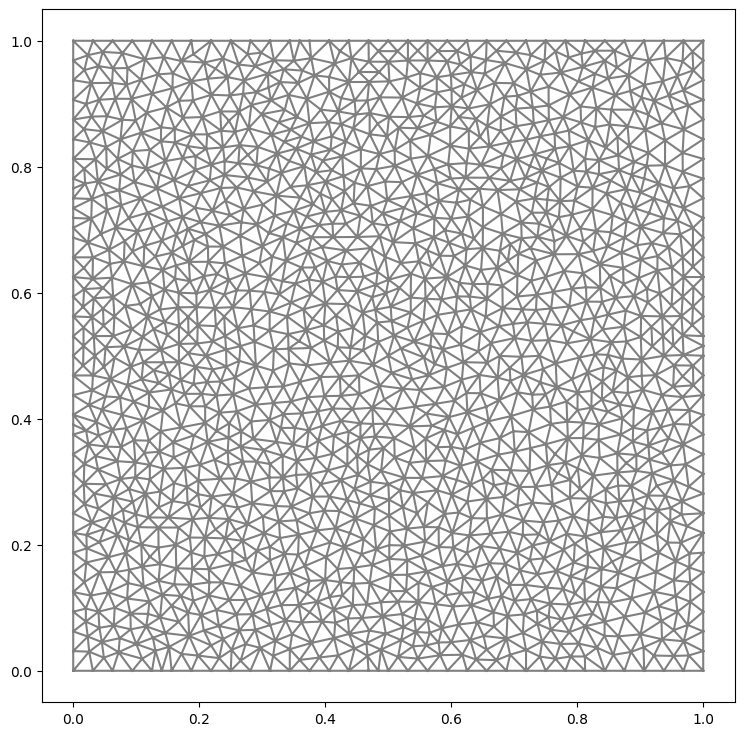

In [3]:
#@title Definizione della geometria $\Omega$
# costruiamo la nostra geometria e generiamo la mesh con circa
# 32 elementi per lato (triangoli di default)
Omega = Rectangle(Point(0, 0), Point(1, 1))
#Omega = Circle(Point(0, 0),1)
mesh = generate_mesh(Omega, 32)
plot(mesh)

In [4]:
#@title Definiamo $ \langle \varphi_i \rangle $  e  $ V_h $ con $ \varphi_i \in \mathbb{P}^1 $
# definiamo le nostre funzioni di base (lagrangiane) sul nostro elemento finito
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh, V_element) # = V_h
del_prints(want_del_prints)

Done!


In [5]:
#@title $v$ ed $u$
# a questo punto:
# definiamo le funzioni trial che useremo nel posto dell'incognita u del sistema lineare
# definiamo le funzioni test con il quale testiamo il problema
u = TrialFunction(V)# corrispondono alle colonne del sistema
v = TestFunction(V) # corrispondono alle righe del sistema

In [6]:
#@title Parametro $\mu$
mu1 = Constant(1.0)
mu2 = Constant(1.0)

mu1.assign(0.0)
mu2.assign(0.2)

In [7]:
#@title Boundary conditions
# definiamo prima la nostra funzione g
g_expr = Expression(bc_str[i], degree=2, mu1=mu1, mu2=mu2)
bc_lifting = DirichletBC(V, g_expr, "on_boundary && \
                      (x[0]<DOLFIN_EPS | x[0]>1.0-DOLFIN_EPS |\
                       x[1]<DOLFIN_EPS | x[1]>1.0-DOLFIN_EPS)")
print("usiamo condizioni al bordo g = " + bc_str[i])

usiamo condizioni al bordo g = mu1 * x[0] + mu2 * x[1]


## Risoluzione del problema

A questo punto riscriviamo la PDE
$$
\begin{cases}
- \Delta u = f \quad & \text{in} \ \Omega \\
u = g \quad & \text{in} \ \partial \Omega
\end{cases}
$$
come
$$
u = w + u_{lift}
$$
dove $\quad w|_{\partial \Omega} = 0 \quad \text{ e } \quad u_{lift}|_{\partial \Omega} = g$
per poi risolvere la PDE usando
$$
- \Delta w = f + \Delta u_{lift} \quad \text{in} \ \Omega, \quad w|_{\partial \Omega} = 0
$$

In [8]:
#@title Assemblaggio del problema con lifting

# definiamo la funzione lifting u_lift, tc u_lift = g su ∂Ω
u_lift = TrialFunction(V) # soddisfa la BC g

# risolviamo -Δ(u_lift) = 0 with u_lift = g on ∂Ω
lhs_lift = inner(grad(u_lift), grad(v)) * dx
rhs_lift = Constant(0.0) * v * dx

LHS_lift = assemble(lhs_lift)
RSH_lift = assemble(rhs_lift)

bc_lifting.apply(LHS_lift)
bc_lifting.apply(RSH_lift)

del_prints(want_del_prints)

Done!


In [9]:
print(type(LHS_lift), type(u_lift), type(RSH_lift))

<class 'dolfin.cpp.la.Matrix'> <class 'dolfin.function.argument.Argument'> <class 'dolfin.cpp.la.Vector'>


In [10]:
#@title Risoluzione del problema con lifting
u_lift_sol = Function(V)
solve(LHS_lift, u_lift_sol.vector(), RSH_lift)

1

In [11]:
#@title Right-hand side del problema omogeneo $f + Δ(u_{lift}) = f - \nabla \cdot ( \nabla u_{lift})$
f = Constant(1.0)
laplacian_u_lift = -div(grad(u_lift_sol))
rhs_expr = f + laplacian_u_lift

In [12]:
#@title Calcolo RHS e LHS per $w:=\tilde{u}$ e risoluzione del problema
# Risolvo per w in: -Δw = f + Δ(u_lift), w = 0 su ∂Ω
w = TrialFunction(V)
lhs_w = inner(grad(w), grad(v)) * dx
rhs_w = rhs_expr * v * dx

LHS_w = assemble(lhs_w)
RHS_w = assemble(rhs_w)

zero_BC = DirichletBC(V, 0.0, "on_boundary")
zero_BC.apply(LHS_w)
zero_BC.apply(RHS_w)

w_sol = Function(V)
solve(LHS_w, w_sol.vector(), RHS_w)

del_prints(want_del_prints)

Done!


In [13]:
#@title unione dei due risultati
# calcolo soluzione finale: u = w + u_lift
u_sol = Function(V)
u_sol.vector()[:] = w_sol.vector() + u_lift_sol.vector()

## Plot delle soluzioni $ u_{lift}, \, w (=\tilde{u}), \, u $

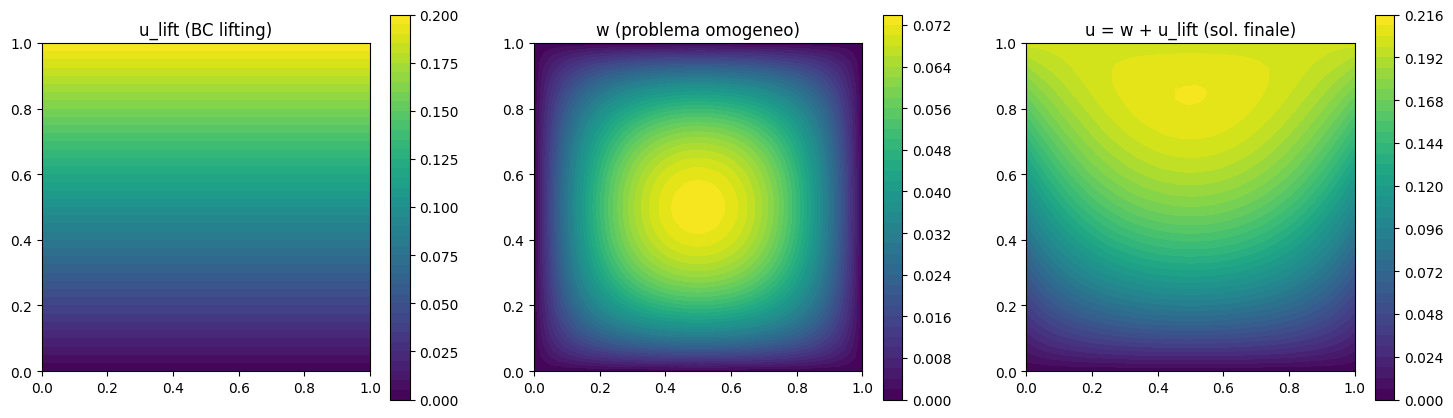

In [14]:
#@title plotting code
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plt.sca(axes[0])
p1=plot(u_lift_sol)
axes[0].set_title("u_lift (BC lifting)")
plt.colorbar(p1)

plt.sca(axes[1])
p2=plot(w_sol)
axes[1].set_title("w (problema omogeneo)")
plt.colorbar(p2)

plt.sca(axes[2])
p3=plot(u_sol)
axes[2].set_title("u = w + u_lift (sol. finale)")
plt.colorbar(p3)

plt.show()


## Truth solver

In [15]:
#@title Truth solver (compressione di tutto ciò in una funzione)

def solve_for(mu1_val,mu2_val, mu1,mu2,V):
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)
    g_expr = Expression(bc_str[i], degree=2, mu1=mu1, mu2=mu2)

    bc_lifting = DirichletBC(V, g_expr, "on_boundary&& \
                      (x[0]<DOLFIN_EPS | x[0]>1.0-DOLFIN_EPS |\
                       x[1]<DOLFIN_EPS | x[1]>1.0-DOLFIN_EPS)")

    # definiamo la funzione lifting u_lift, tc u_lift = g su ∂Ω
    u_lift = TrialFunction(V) # soddisfa la BC g

    # risolviamo -Δ(u_lift) = 0 with u_lift = g on ∂Ω
    lhs_lift = inner(grad(u_lift), grad(v)) * dx
    rhs_lift = Constant(0.0) * v * dx

    LHS_lift = assemble(lhs_lift)
    RSH_lift = assemble(rhs_lift)

    bc_lifting.apply(LHS_lift)
    bc_lifting.apply(RSH_lift)

    u_lift_sol = Function(V)
    solve(LHS_lift, u_lift_sol.vector(), RSH_lift)

    f = Constant(1.0)
    laplacian_u_lift = -div(grad(u_lift_sol))
    rhs_expr = f + laplacian_u_lift

    w = TrialFunction(V)
    lhs_w = inner(grad(w), grad(v)) * dx
    rhs_w = rhs_expr * v * dx

    LHS_w = assemble(lhs_w)
    RHS_w = assemble(rhs_w)

    zero_BC = DirichletBC(V, 0.0, "on_boundary&& \
                      (x[0]<DOLFIN_EPS | x[0]>1.0-DOLFIN_EPS |\
                       x[1]<DOLFIN_EPS | x[1]>1.0-DOLFIN_EPS)")
    zero_BC.apply(LHS_w)
    zero_BC.apply(RHS_w)

    w_sol = Function(V)
    solve(LHS_w, w_sol.vector(), RHS_w)

    # calcolo soluzione finale: u = w + u_lift
    u_sol = Function(V)
    u_sol.vector()[:] = w_sol.vector() + u_lift_sol.vector()

    del_prints(want_del_prints)
    return u_sol.copy(deepcopy=True)


In [16]:
mu1 = Constant(1.0)
mu2 = Constant(1.0)

mu1_val = 0
mu2_val = 0.2
u_sole = solve_for(mu1_val,mu2_val, mu1,mu2,V)

Done!


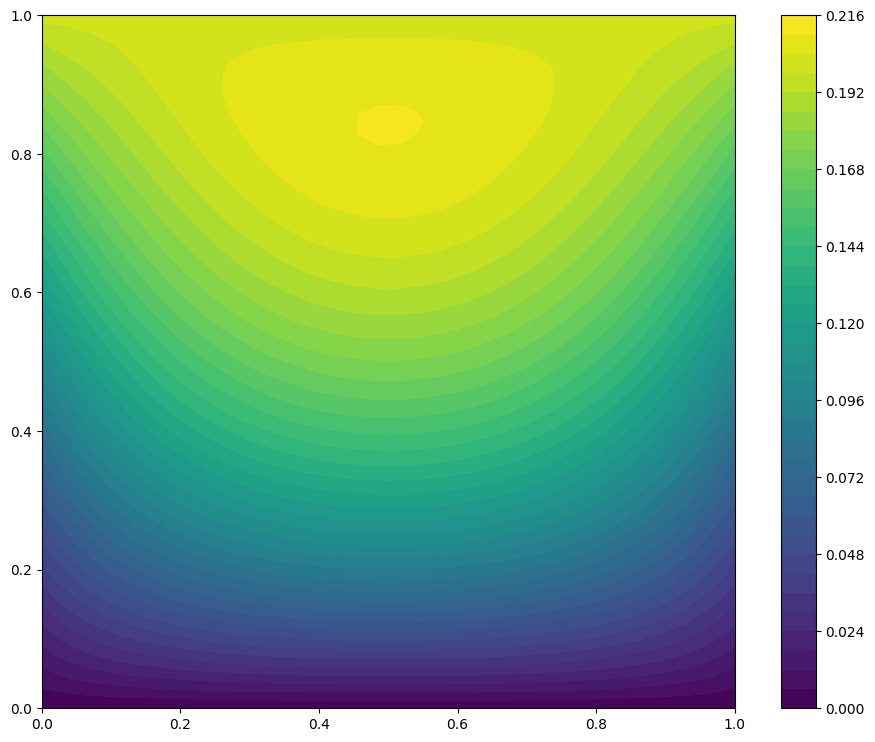

In [17]:
plt_ue=plot(u_sole)
plt.colorbar(plt_ue)

In [18]:

# Definiamo una griglia di parametri e raccogliamo snapshot

mu1_vals = np.logspace(-4, 4, 20)
mu2_vals = np.logspace(-4, 4, 20)
snapshots = []

for m2 in mu2_vals:
    m1 = 0
    sol = solve_for(m1,m2, mu1,mu2,V)
    snapshots.append(sol.vector().get_local())

# Costruiamo la matrice snapshot U
U = np.array(snapshots).T  # dimensione: [N_dof, M]

# Eseguiamo la SVD
U_mean = np.mean(U, axis=1, keepdims=True)
U_centered = U - U_mean
U_basis, S, Vh = svd(U_centered, full_matrices=False)

# Numero di funzioni base ridotte da conservare
N = 5
RB = U_basis[:, :N]  # colonne = basi ridotte

print(f"Costruito spazio ridotto con {N} basi su {U.shape[0]} DOF originali.")


Done!
Costruito spazio ridotto con 5 basi su 1657 DOF originali.


## Considerazioni

Proprietà utile:
Il problema è **coercivo** (Poisson su dominio limitato con $a(x;\mu) \geq 0.1$) \
- Ricordiamo che:\
data una forma bilineare $a(u,v;\mu)$ diciamo che questa è coerciva se $a(u,v;\mu) \geq \alpha(\mu) \ ||v||^2_{H_0^1}$ con $\alpha(\mu)$coefficiente di coercività.
- in altre parole:
  - $a(\cdot,\cdot;\mu)$ controlla la norma $ ||v||$
  - Nessuna "direzione" di $v$ può sfuggire al controllo (nessuna degenerazione)

\
Nel nostro caso abbiamo:

1. $a(x;\mu) \geq \underline{a} > 0$ per ogni $x \in \Omega$, $\mu \in \mathcal{P}$  
   - Ad esempio: $a(x;\mu) = 1 + \mu_1 x_1 \geq 1$ (dato che $\mu_1 \geq 0.1$, $x_1 \in [0,1]$)  
   - $\Rightarrow a(x;\mu) \geq 1 \Rightarrow \alpha(\mu) \geq 1$

2. Il dominio $\Omega$ è limitato e regolare, quindi:
   - Poincaré: $\|v\|_{L^2} \leq C \|\nabla v\|$
   - $\Rightarrow$ la norma $H^1_0$ è equivalente a $\|\nabla v\|$

3. La forma bilineare è:
   $$
   a(u,v;\mu) = \int_\Omega a(x;\mu) \nabla u \cdot \nabla v \, dx
   $$
   che è **simmetrica**, **positiva definita**, e **uniformemente ellittica**

\
Vantaggi:
- Esistenza e unicità della soluzione per il teorema di Lax-Milgram
- Stabilità numerica per Finite Element Method (FEM)
- Errori stimabili a posteriori
- RBM certificabile cioè è possibile stimare l’errore tra soluzione ridotta e completa
- Convergenza garantita: Greedy converge rapidamente se l'errore è controllato da coercività

\
Senza coercività?

Se $\alpha(\mu) \to 0$ (cioè $a(x;\mu)$ vicino a 0):

- Il problema diventa quasi-degenerato
- L’errore esplode (stimatore → infinito)
- FEM diventa instabile
- RBM non può certificare nulla
---

\

Obiettivo nel contesto RBM

- Costruire base ridotta (POD o greedy)
- Stimare errore e certificare $\eta(\mu)$
- Visualizzare:
  - errore vs. $N$ basi
  - errore/estimatore vs. parametro
  - speedup vs. full FEM

##Reduced Order Method

In [19]:
#ground_truth =